In [74]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    recall_score,
    precision_score,
)
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt

In [75]:
X_test = pd.read_csv('X_test.csv').reset_index(drop=True).drop('Unnamed: 0', axis=1)
y_test = pd.read_csv('y_test.csv')
X_train = pd.read_csv('X_train.csv').drop('Unnamed: 0', axis=1).reset_index(drop=True)
y_train = pd.read_csv('y_train.csv')
y_train['label'] = y_train['label'].replace({False: 0, True: 1})
y_test['label'] = y_test['label'].replace({False: 0, True: 1})


In [77]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train['label'])
y_pred  = model.predict(X_test)

**Confusion matrix**

In [78]:
acc = accuracy_score(y_test['label'], y_pred)
sens = recall_score(y_test['label'], y_pred)
prec = precision_score(y_test['label'], y_pred)

print("Accuracy:", acc)
print("Sensitivity:", sens)
print("Precision:", prec)

Accuracy: 0.8016528925619835
Sensitivity: 0.792
Precision: 0.8181818181818182


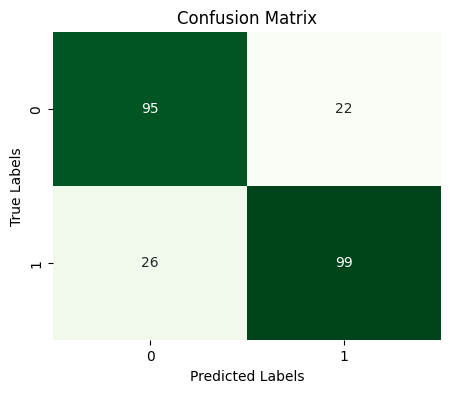

In [79]:
cm = confusion_matrix(y_test['label'], y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, cmap="Greens", fmt="d", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

**Feature Importance**

In [80]:
print("important features")
importances = model.feature_importances_
columns_enumeration = [(column, i) for i, column in enumerate(X_train.columns)]
columns_enumeration.sort()
for column, i in columns_enumeration:
    print(f"{column}:{round(importances[i], ndigits=3)} - Index: {i}", end="\n")

important features
d0:0.07 - Index: 2
d1:0.071 - Index: 6
d2:0.062 - Index: 10
d3:0.069 - Index: 14
reaction0:0.007 - Index: 1
reaction1:0.007 - Index: 5
reaction2:0.006 - Index: 9
reaction3:0.008 - Index: 13
reaction_ref:0.006 - Index: 0
same_profile0:0.038 - Index: 4
same_profile1:0.055 - Index: 8
same_profile2:0.043 - Index: 12
same_profile3:0.032 - Index: 16
timegap0:0.102 - Index: 3
timegap1:0.096 - Index: 7
timegap2:0.132 - Index: 11
timegap3:0.196 - Index: 15


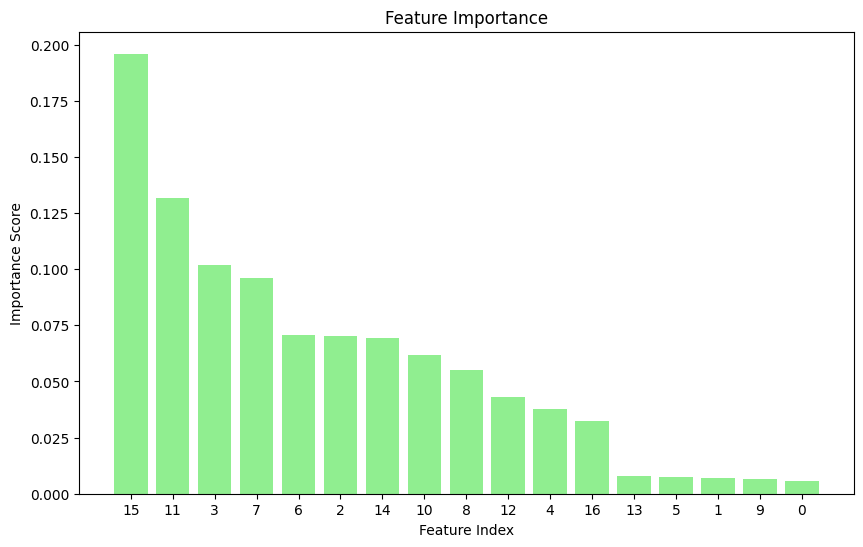

In [81]:
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices], align="center", color = 'lightgreen')
plt.xticks(range(X_train.shape[1]),indices) #[columns_enumeration[i] for i in indices])
plt.xlabel("Feature Index")
plt.ylabel("Importance Score")
plt.show()

**Permutation Importance**

Permutation Importance evaluates the drop in model performance when the values of a feature are randomly shuffled. A larger drop indicates higher importance.

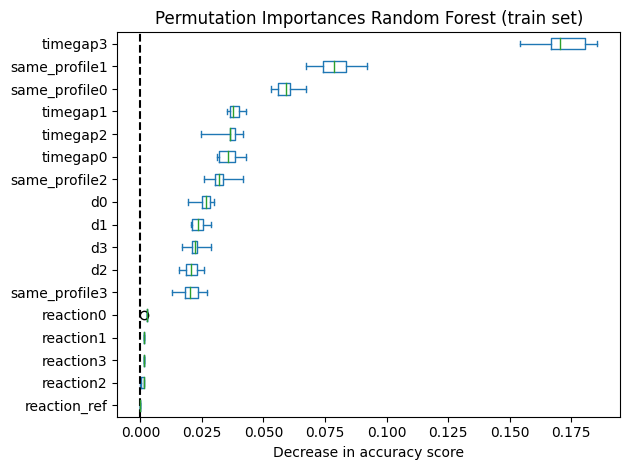

In [82]:
perm_importance_rf = permutation_importance(model, X_train, y_train['label'], n_repeats=10, random_state=42)
sorted_importances_idx = perm_importance_rf.importances_mean.argsort()
importances = pd.DataFrame(
    perm_importance_rf.importances[sorted_importances_idx].T,
    columns=X_test.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances Random Forest (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

Tree's Feature Importance from Mean Decrease in Impurity (MDI): the impurity-based feature importance ranks the numerical features to be the most important features.

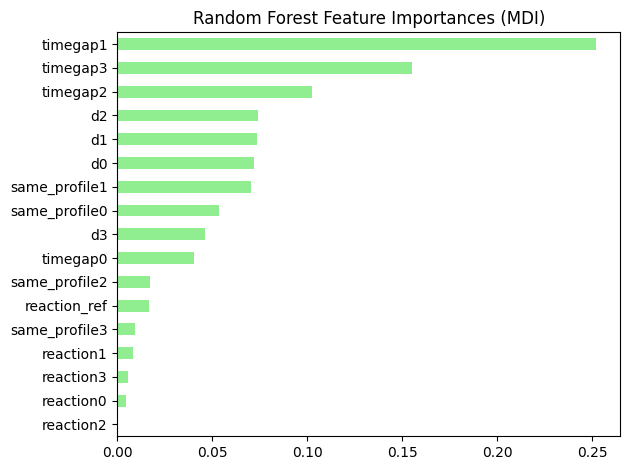

In [83]:
feature_names = X_train.columns

mdi_importances = pd.Series(
    model[-1].feature_importances_, index=feature_names
).sort_values(ascending=True)
ax = mdi_importances.plot.barh(color = 'lightgreen')
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

**Predicted vs True new conversations**

In [86]:
df = pd.read_csv('new_conversation.csv')
X_test = pd.read_csv('X_test.csv')
X = pd.concatenate([X_test, y_test], axis = 1)
subset_df = pd.merge(X, df, on='id', how='inner')

KeyError: 'id'

Highlight using different colors the *true* (black) and *predicted* (blue) and *correct prediction* (green) changes in conversations detected by RandomForest on the test set.

In [ ]:
grouped = subset_df.groupby('group')
num_plots = len(grouped)
fig, axes = plt.subplots(num_plots, 1, figsize=(15, 5*num_plots))

true_drifts = []
predicted_drifts = []

for i, (group, group_data) in enumerate(grouped):
    n_drift_true = 0
    n_drift_predicted = 0
    new_conversation = group_data['new_conversation'] == 'yes'
    axes[i].scatter(group_data['date'], new_conversation, label=group, marker='.',linewidth = 2, color='#FF5733')

    prev_status = None
    flag_true = 0
    flag_pred = 0
    for date, message_id, status in zip(group_data['date'], group_data['Unnamed: 0'], new_conversation): #CHECK FOR INDEX OR ID
        idx = subset_df[subset_df['id'] == message_id].index

        if y_test.iloc[idx]['label'] == 1:
            n_drift_true += 1
            flag_true = 1

        if y_pred.iloc[idx]['label'] == 1:
            n_drift_predicted += 1
            flag_pred = 1


        # if true and predicted coincide, use a green line
        if flag_pred == 1 and flag_true == 1:
          axes[i].axvline(x=date, color='green', linestyle='-', linewidth=0.3, label = 'Coincide')
        elif flag_pred == 1:
          axes[i].axvline(x=date, color='blue', linestyle='-', linewidth=0.3, label = 'Predicted Change')
        elif flag_true == 1:
            axes[i].axvline(x=date, color='black', linestyle='-', linewidth=0.3, label = 'True Change')

        prev_status = status
        flag_true = 0
        flag_pred = 0

    axes[i].set_title(f'Drift-Group: {group}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('New Conversation')

    true_drifts.append((n_drift_true, group))
    predicted_drifts.append((n_drift_predicted, group))

plt.tight_layout()
plt.legend()
plt.show()

Compare frequency of *true* and *predicted* changes in conversations detected by RandomForest on the test set.

In [ ]:
bar_width = 0.35

index = np.arange(len(grouped))

plt.barh(index, true_drifts, bar_width, label='True Drifts', color='lightblue')
plt.barh(index + bar_width, predicted_drifts, bar_width, label='Predicted Drifts', color='lightgreen')

plt.xlabel('Number of Drifts')
plt.ylabel('Group')
plt.title('Number of True and Predicted Drifts per Group')
plt.yticks(index + bar_width / 2, grouped)

plt.legend()
plt.show()
